# **Exercise 1 (Surrogate modeling and Monte Carlo for an anti-hail shield)**

As climate change intensifies, extreme weather events like hailstorms have become a significant threat. To address this, a company is developing an innovative anti-hail shield designed to absorb the impact of falling hailstones. The shield is made of thermoplastic polyurethane (TPU), a highly elastic material ideal for absorbing and dissipating impact energy from hail, and capable of maintaining its elasticity over a wide range of temperatures.

As a first approximation, we can model a small portion of the shield as a $6\text{cm} \times 6\text{cm}$ cube (the average size of a marble-sized hailstone is $1.2\text{cm}$ in diameter). To further simplify, assuming suitable symmetries, we shall limit our analysis to a 2D section of the shield, describing the impact of a hailstone in the $xz$-plane. Let $\theta$ be the angle of incidence (e.g.: $\theta = \pi/2$ means the hailstone falls vertically, parallel to the $z$-axis). Let $m$ be the mass of the hailstone. Let $\lambda, \nu$ be the Lamé coefficients of the shield.

We model the deformation of the shield caused by the falling hailstone using the equations of linear elasticity,

$$
\begin{cases}
-\nabla \cdot \left( \lambda \nabla \cdot \mathbf{u} + \nu \left( \nabla \mathbf{u} + \nabla \mathbf{u}^\top \right) \right) = \mathbf{f} \quad &\text{in } \Omega, \\
\mathbf{u} \equiv 0  \quad &\text{on } \Gamma, \\
\lambda (\nabla \cdot \mathbf{u}) \cdot \mathbf{n} + \nu (\nabla \mathbf{u} + \nabla \mathbf{u}^\top) \cdot \mathbf{n} = 0  \quad &\text{on } \partial\Omega \setminus \Gamma.
\end{cases}
$$

Here, $\Omega = (0,1)^2$ is the unit square, representing a normalized 2D slice of the shield. $\Gamma_{\text{down}} = \{0\} \times [0,1]$ and $\Gamma_u = \{1\} \times [0,1]$ are the bottom edge and the top edge, respectively. The vector field $\mathbf{u} : \Omega \to \mathbb{R}^2$, instead, is the displacement field, assigning a local deformation to every point in $\Omega$, whereas $\mathbf{n}$ is the external unit normal.

The —normalized— external forces are

$$
\mathbf{f} \equiv -\frac{1}{2}
\quad \text{and} \quad
T(x,y) = \mathbf{1}_{[0.4,0.6]}(x) \cdot [\cos \theta, -\sin \theta]^\top,
$$

modeling: a constant body-force caused by the shield’s own weight ($\mathbf{f}$), and a contact force caused by the falling hailstone ($T$), respectively.


Let $\boldsymbol{\mu} := [\lambda, \nu, \theta, m]^\top$. We consider the following range of values,

$$
0.9 \leq \lambda \leq 1.1, \quad 0.5 \leq \nu \leq 1.0, \quad \frac{\pi}{4} \leq \theta \leq \frac{3\pi}{4}, \quad 1 \leq m \leq 1.5.
$$

Given the problem parameters, let $\mathbf{u} = \mathbf{u}_{\boldsymbol{\mu}} = \mathbf{u}_{\lambda, \nu, \theta, m}$ be the solution to (1).  

You are given access\(^*\) to a dataset of $N = 200$ pre-computed random simulations $\{\boldsymbol{\mu}_i, \mathbf{u}_i\}_{i=1}^{N}$, where the problem parameters have been drawn independently and uniformly within their respective range. In the dataset, each PDE solution is represented as a discrete vector, $\mathbf{u}$, with $N_h = 882$ degrees of freedom (obtained by considering a $21 \times 21$ uniform grid over the unit cube).



In [ ]:
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

from IPython.display import clear_output as clc
import numpy as np
import matplotlib.pyplot as plt
import gdown

In [ ]:
# Auxiliary functions for plotting and forward UQ
def deformed_mesh(u):
  from fenics import UnitSquareMesh, vertex_to_dof_map, FunctionSpace
  deformed = UnitSquareMesh(20, 20)
  permutation = vertex_to_dof_map(FunctionSpace(deformed, 'CG', 1))
  clc()
  x_delta = u[::2]+0.0
  y_delta = u[1::2]+0.0
  deformed.coordinates()[:, 0] = deformed.coordinates()[:, 0] + x_delta[permutation]
  deformed.coordinates()[:, 1] = deformed.coordinates()[:, 1] + y_delta[permutation]
  return deformed

def object_position(u):
  from fenics import UnitSquareMesh
  deformed = deformed_mesh(u)
  nodes = UnitSquareMesh(20, 20).coordinates()[:, 1]>1-1e-10
  return deformed.coordinates()[nodes][deformed.coordinates()[nodes][:, 1].argmin()]

def Q(u):
  return 1.0-object_position(u)[1]

In [ ]:
# Data
gdown.download(id = '1f9jydxPxUeBMQEi533xqyv-bLnSqCnfK', output = 'shield_data.npz')
dataset = np.load('shield_data.npz')
mu, u = dataset['mu'], dataset['u']
clc()

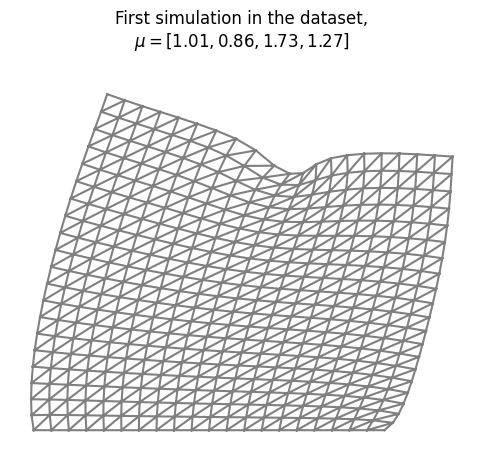

In [ ]:
# Visualization
fe.plot(deformed_mesh(u[80]))
plt.title("First simulation in the dataset,\n$\mu = [%.2f,%.2f,%.2f,%.2f]$\n" % tuple(mu[0]))
None

In [ ]:
Q(u[0]) # Maximum vertical deformation for the above simulation

0.26926512559129234

### (a)
Design and train a suitable **reduced order model** of your choice (POD-NN or DL-ROM) to approximate the map

$$
\mathbb{R}^4 \ni [\lambda, \nu, \theta, m]^\top \mapsto \mathbf{u}_{\lambda, \nu, \theta, m} \in \mathbb{R}^{882}.
$$

To this end, use 150 simulations for training and validation, keeping 50 for the testing phase. What is the **average relative error** of your model (in Euclidean norm) over the test set?




In [ ]:
u.shape

(200, 882)

In [ ]:
from scipy.linalg import svd

In [ ]:
n_train = 150
n_test = 50

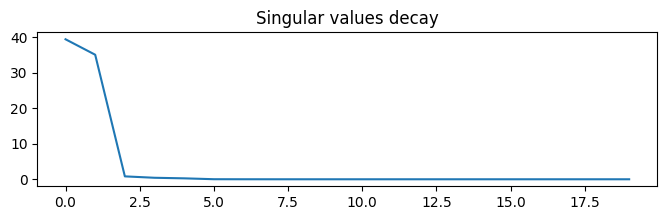

In [ ]:
X, s, Yt = svd(u[:n_train].T, full_matrices = False)
plt.figure(figsize = (8, 2))
plt.plot(s[0:20])
plt.title("Singular values decay")
plt.show()

In [ ]:
n = 5
V = X[:, :n]
V.shape

(882, 5)

In [ ]:
u[0].shape

(882,)

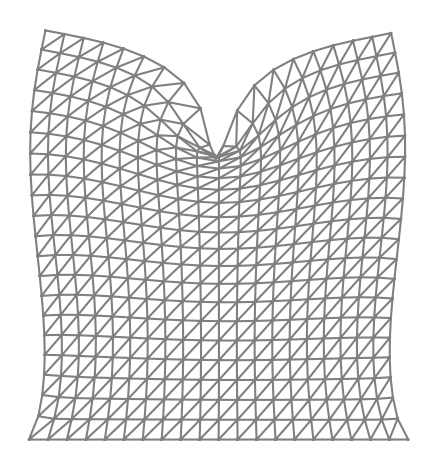

In [ ]:
fe.plot(deformed_mesh(V[:,3].flatten()))
plt.tight_layout()

In [ ]:
u_proj = u @ V @ V.T
u_proj.shape, u.shape

((200, 882), (200, 882))

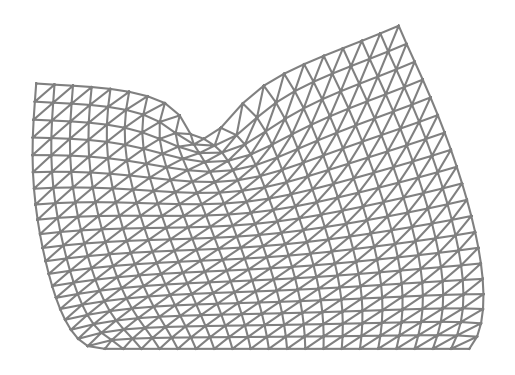

In [ ]:
fe.plot(deformed_mesh(u_proj[10].flatten()))

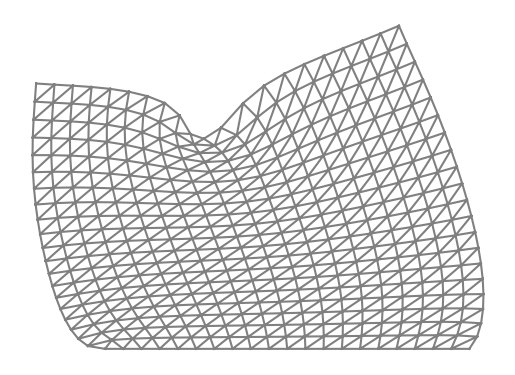

In [ ]:
fe.plot(deformed_mesh(u[10].flatten()))

In [ ]:
mre = lambda norm: lambda true, pred: (norm(true-pred)/norm(true)).mean()
def euclidean(v):
    return np.sqrt(np.sum(v**2))

In [ ]:
mre(euclidean)(u[n_train:], u_proj[n_train:])

0.0003361094357093823

In [ ]:
from dlroms import*
mu, u, u_proj, V = dv.tensor(mu, u, u_proj, V)
clc()

In [ ]:
c_mu = u @ V
c_mu.shape

torch.Size([200, 5])

In [ ]:
p = mu.shape[1]
phi = Dense(p, 30) + Dense(30, 30) + Dense(30, n, activation = None)
model = DFNN(phi)
model.He()
model.train(mu, c_mu, ntrain = n_train-25, nvalid=25, epochs = 100, loss = mse(euclidean))

		Train		Valid		Test
Epoch 100:	2.89e-03	6.76e-03	1.17e-02.

>> ETA: 0.14s.

Training complete. Elapsed time: 14.32 seconds.


In [ ]:
u_pred = model(mu[n_train:])
u_pred.shape

torch.Size([50, 5])

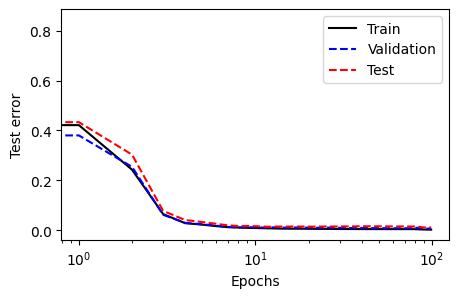

In [ ]:
model.freeze()
n_epochs = len(model.errors['Train'])
plt.figure(figsize = (5, 3))
plt.semilogx(model.errors['Train'], '-k', label = 'Train')
plt.semilogx(model.errors['Validation'], '--b', label = 'Validation')
plt.semilogx(model.errors['Test'], '--r', label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Test error')
plt.legend()
plt.show()

In [ ]:
mre(euclidean)(c_mu[n_train:], u_pred)

tensor(0.0228, grad_fn=<MeanBackward0>)

In [ ]:
u_rom = model(mu) @ V.T
u[n_train:].shape, u_rom.shape

(torch.Size([50, 882]), torch.Size([200, 882]))

In [ ]:
mre(euclidean)(u[n_train:], u_rom[n_train:])

tensor(0.0244)

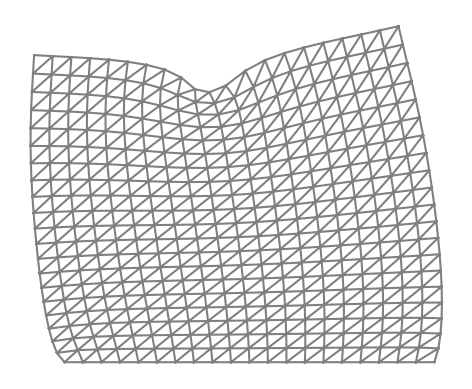

In [ ]:
fe.plot(deformed_mesh(u_rom.numpy()[0].flatten()))

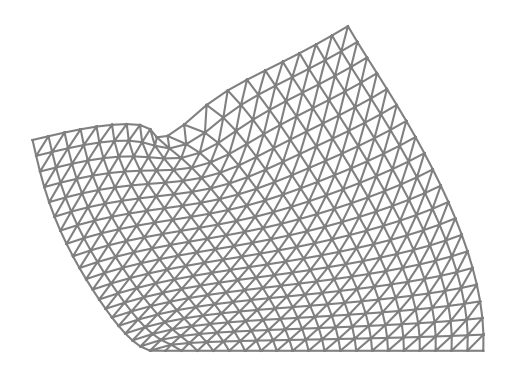

In [ ]:
fe.plot(deformed_mesh(u.numpy()[n_train].flatten()))

### (b)
Let $\mathbf{u} = [u^{(x)}, u^{(z)}]^\top$ denote the $x, z$ components of the displacement vector field. We are interested in the following quantity of interest\(^*\),

$$
Q_{\boldsymbol{\mu}} := \max_{(x,y) \in \Gamma_{\text{up}}} |u^{(z)}(x,y)|,
\tag{2}
$$

which measures the **maximum deformation** of the top edge of the shield along the $z$-axis, corresponding to the penetration depth of the falling hailstone.

Ignoring the reduced order model constructed at point (a), use the 200 simulations in the dataset to estimate $\mathbb{E}[Q_{\boldsymbol{\mu}}]$ via classical **Monte Carlo**. In doing so, compute also a **95% confidence interval**.



In [ ]:
u = u.detach().numpy()
u_rom = u_rom.detach().numpy()
mu = mu.detach().numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [ ]:
from scipy.stats import norm

In [ ]:
N = 200
Q_values = np.array([Q(u[i]) for i in range(N)])

# Monte-Carlo estimate
EQ = np.mean(Q_values)

# Compute standard error
std_err = np.std(Q_values, ddof=1) / np.sqrt(N)

# 95% confidence interval
z = norm.ppf(0.975)
conf_int = (EQ - z * std_err, EQ + z * std_err)

EQ, std_err, conf_int

(0.29848757058382036,
 0.00357048933890596,
 (0.2914895400723804, 0.3054856010952603))



### (c)
Let $Q_{\boldsymbol{\mu}}$ and $\tilde{Q}_{\boldsymbol{\mu}}$ denote the values of the quantity of interest when the shield deformation is computed either relying on the ground truth or the reduced order model, respectively. Consider the first $q = 25$ simulations in the test set of point (a), $\{\boldsymbol{\mu}_i^{\text{test}}, \mathbf{u}_i^{\text{test}}\}$. Compute $\{Q_{\boldsymbol{\mu}_i^{\text{test}}}\}_{i=1}^{q}$ and $\{\tilde{Q}_{\boldsymbol{\mu}_i^{\text{test}}}\}_{i=1}^{q}$. Use this data to estimate

$$
\rho \approx \operatorname{Cov}(Q_{\boldsymbol{\mu}}, \tilde{Q}_{\boldsymbol{\mu}}), \quad \sigma^2 \approx \operatorname{Var} Q_{\boldsymbol{\mu}}, \quad \tilde{\sigma}^2 \approx \operatorname{Var} \tilde{Q}_{\boldsymbol{\mu}},
$$

that is the **correlation coefficient**, the FOM variance, and the ROM variance relative to $Q$. To this end, you can rely on classical formulae: cf. `numpy.corrcoef`.



In [ ]:
Q_data = np.array([Q(u[i]) for i in range(n_train, n_train+n_test-25)])
Q_data.shape

(25,)

In [ ]:
Qrom_data = np.array([Q(u_rom[i]) for i in range(n_train, n_train+n_test-25)])
Qrom_data.shape

(25,)

In [ ]:
fom_var = np.var(Q_data)
rom_var = np.var(Qrom_data)
rho = np.corrcoef(Q_data, Qrom_data)[0, 1]
fom_var, rom_var, rho

(0.002470993535835839, 0.002603080662489935, 0.9973085829882238)



### (d)
Starting from point (c), consider the following **multi-fidelity estimator** for $\mathbb{E}[Q_{\boldsymbol{\mu}}]$, obtained by combining the remaining 25 reference simulations in the test set with a large number $M$ of new "low-fidelity" simulations produced using the surrogate model,

$$
E_{q,M} := \frac{1}{q} \sum_{i=1}^{q} Q_{\boldsymbol{\mu}_i^{\text{mf}}} + \frac{\rho\sigma}{\tilde{\sigma}} \left( \frac{1}{q+M} \sum_{i=1}^{q+M} \tilde{Q}_{\boldsymbol{\mu}_i^{\text{mf}}} - \frac{1}{q} \sum_{i=1}^{q} \tilde{Q}_{\boldsymbol{\mu}_i^{\text{mf}}} \right).
\tag{3}
$$

Here,

$$
[\boldsymbol{\mu}_1^{\text{mf}}, \dots, \boldsymbol{\mu}_{q+M}^{\text{mf}}]^\top = [\boldsymbol{\mu}_{25}^{\text{test}}, \dots, \boldsymbol{\mu}_{50}^{\text{test}}, \boldsymbol{\mu}_1^{\text{new}}, \dots, \boldsymbol{\mu}_M^{\text{new}}]^\top
$$

is a list combining the remaining test instances and the newly drawn parameter values (sampled independently and uniformly from the parameter space).

The **MSE** for this estimator is

$$
\operatorname{MSE}(E_{q,M}) = \frac{\sigma^2}{q} + \left( \frac{1}{q} - \frac{1}{M} \right) (1 - 2\rho^2) \sigma^2.
\tag{4}
$$

Set $M = 10^5$. Use (3) and (4) to compute a **95% confidence interval** for $\mathbb{E}[Q_{\boldsymbol{\mu}}]$. Compare your results with the ones at point (b): **has the uncertainty been reduced? How much?**

In [ ]:
import torch

In [ ]:
u_new = model(mu[n_train:])

In [ ]:
M = 100000

# Generate new random parameters mu
mu_min = np.array([0.9, 0.5, np.pi/4, 1.0])
mu_max = np.array([1.1, 1.0, 3*np.pi/4, 1.5])

mu_new = np.random.uniform(low=mu_min, high=mu_max, size=(M, 4))
mu_new

array([[1.09861856, 0.6912277 , 1.75969157, 1.30309496],
       [0.91055543, 0.59311144, 1.2287613 , 1.33007814],
       [1.06523377, 0.90478581, 1.21330501, 1.48631564],
       ...,
       [0.98884323, 0.80213757, 1.5098967 , 1.2658565 ],
       [0.99700261, 0.68948815, 2.07599752, 1.03208078],
       [0.99708947, 0.50109841, 0.86325649, 1.35931043]])

In [ ]:
mu_new = dv.tensor(mu_new)

u_new = model(mu_new)
u_new = u_new @ V.T
u_new = u_new.detach().numpy()
u_new.shape

(100000, 882)

In [ ]:
u[n_train+n_test-25:].shape, u_new.shape, u_rom.shape

((25, 882), (100000, 882), (200, 882))

In [ ]:
# Compute Q values for the remaining test instances
Q_mf = np.array([Q(u[i]) for i in range(n_train + n_test - 25, n_train + n_test)])
Q_tilde_mf = np.array([Q(u_rom[i]) for i in range(n_train + n_test - 25, n_train + n_test)])


In [ ]:
# Compute Q_tilde values for the new simulations
Q_tilde_new = np.array([Q(u_new[i]) for i in range(M)])

# Compute the multi-fidelity estimator
q = len(Q_mf)
E_qM = (1/q) * np.sum(Q_mf) + (rho * np.sqrt(fom_var) / np.sqrt(rom_var)) * (
    (1 / (q + M)) * np.sum(Q_tilde_new) - (1 / q) * np.sum(Q_tilde_mf)
)

In [ ]:
E_qM

0.30007772318254

In [ ]:
# Compute the MSE
MSE_E_qM = (fom_var / q) + ((1 / q) - (1 / M)) * (1 - 2 * (rho**2)) * fom_var

# Compute the standard error for the multi-fidelity estimator
std_err_mf = np.sqrt(MSE_E_qM)


# Compute 95% confidence interval for the multi-fidelity estimator
z = norm.ppf(0.975)
conf_int_mf = (E_qM - z * std_err_mf, E_qM + z * std_err_mf)


print(f"Multi-fidelity Estimator E_qM: {E_qM}")
print(f"Standard Error (Multi-fidelity): {std_err_mf}")
print(f"95% Confidence Interval (Multi-fidelity): {conf_int_mf}")

# Comparison with Monte Carlo
print(f"\nMonte Carlo Estimate EQ: {EQ}")
print(f"Standard Error (Monte Carlo): {std_err}")
print(f"95% Confidence Interval (Monte Carlo): {conf_int}")

# Uncertainty reduction
uncertainty_reduction = (std_err - std_err_mf) / std_err * 100

print(f"\nUncertainty Reduction: {uncertainty_reduction:.2f}%")

Multi-fidelity Estimator E_qM: 0.30007772318254
Standard Error (Multi-fidelity): 0.0010426352116621512
95% Confidence Interval (Multi-fidelity): (0.2980341957186689, 0.3021212506464111)

Monte Carlo Estimate EQ: 0.29848757058382036
Standard Error (Monte Carlo): 0.00357048933890596
95% Confidence Interval (Monte Carlo): (0.2914895400723804, 0.3054856010952603)

Uncertainty Reduction: 70.80%
